In [98]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
unique_isoform_df = pd.read_csv("../data/unique_isoforms_and_aln_stats.tsv", sep="\t").dropna()

unique_isoform_df.head()

,win_chr,win_start,win_end,total_isoform,isoform_name,sample_from,sample_compared_to,mapped_start,isoform_sequence,selected_alignments
0,NC_060925.1,255178,288416,4,PB.6.2,HG002,HG004,255184,GGAGCCAAGGTCCGCTCGGGTGAGTGCCCTCCGCTTTTTGTGGCCA...,0.02_HG004_PB.6.2_3=6D1=3D1286=11D
1,NC_060925.1,255178,288416,4,PB.6.2,HG002,HG005,255184,GGAGCCAAGGTCCGCTCGGGTGAGTGCCCTCCGCTTTTTGTGGCCA...,0.02_HG004_PB.6.2_3=6D1=3D1286=11D
2,NC_060925.1,255178,288416,4,PB.6.2,HG004,HG002,255173,GGATTATCCGGAGCCAAGGTCCGCTCGGGTGAGTGCCCTCCGCTTT...,0.02_HG002_PB.6.2_3=6I1=3I1286=11I
3,NC_060925.1,255178,288416,4,PB.6.2,HG004,HG005,255173,GGATTATCCGGAGCCAAGGTCCGCTCGGGTGAGTGCCCTCCGCTTT...,0.02_HG002_PB.6.2_3=6I1=3I1286=11I
4,NC_060925.1,255178,288416,4,PB.7.3,HG005,HG002,270164,CCCCGCTGCGCGCGTTTCTGGCCCTGCCAGTGTCTCCGCCGGTTGA...,0.54_HG005_PB.7566.3_2X2D3=2X1=1D1=1D2=1X2=2X1...


In [99]:
unique_isoform_df["isoform_sequence"].apply(lambda x: len(x)).mean()

2662.5089486615802

In [100]:
unique_isoform_df["normalized_distance"] = unique_isoform_df.apply(lambda x: x["selected_alignments"].split("_")[0], axis=1)
unique_isoform_df["cigar_string"] = unique_isoform_df.apply(lambda x: x["selected_alignments"].split("_")[3], axis=1)

In [101]:
unique_isoform_df["read_id"] = unique_isoform_df.apply(lambda x:x["isoform_name"]+"_"+x["sample_from"], axis=1)

In [102]:
cigar_df = unique_isoform_df[["isoform_name", "sample_from","cigar_string"]].drop_duplicates()

In [114]:
def get_edit_pos(cigar):
    pos = 0
    indel_pos = []
    mismatch_pos = []
    for length, letter, match in re.findall('(\d+)([A-Za-z])?(=)?', cigar):
        length = int(length)
        for i in range(length):
            if letter == "D" or letter == "I":
                indel_pos.append(pos)
                pos += 1
            elif letter == "X":
                mismatch_pos.append(pos)
                pos += 1
            else:
                pos += length
                break
    return [int(l/pos*2663) for l in indel_pos], [int(l/pos*2663) for l in mismatch_pos]

In [127]:
def plot_indel_mismatch_pos(cigar_strings, label=""):
    all_indel_pos = []
    all_mismatch_pos = []
    for cigar in tqdm(cigar_strings):
        indel_pos, mismatch_pos = get_edit_pos(cigar)
        all_indel_pos += indel_pos
        all_mismatch_pos += mismatch_pos
        
    fig, ax = plt.subplots(2, sharex=True)
    ax[0].hist(all_indel_pos,bins=2663)
    ax[1].hist(all_mismatch_pos,bins=2663)

    ax[0].set_xlabel("Normalized locations on isoform")
    ax[0].set_ylabel("Number of indel")
    ax[1].set_xlabel("Normalized locations on isoform")
    ax[1].set_ylabel("Number of mismatches")
    
    ax[0].set_title("Distribution of edits on isoform alignments, sample %s" % label)
    
    fig.set_size_inches(10,8)

100%|██████████| 72575/72575 [00:10<00:00, 7169.24it/s]


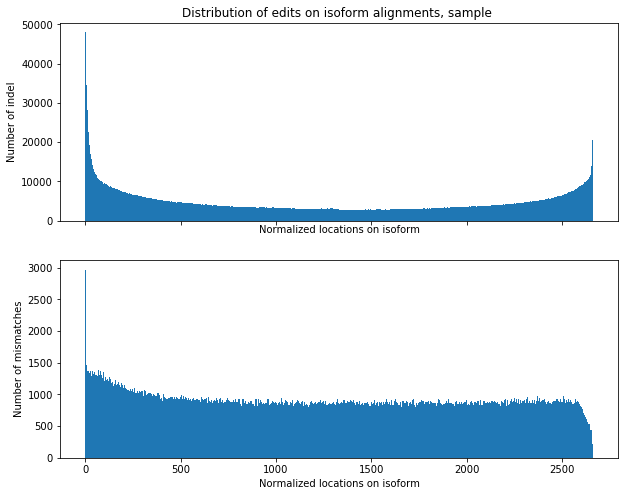

In [128]:
plot_indel_mismatch_pos(cigar_df["cigar_string"])